In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=2299fc258286bfc9b596d7d79770c96b8b7086f821c1f400ed9f6b9989da7d9d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import zipfile
import wget
import shutil

In [5]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/computer-vision-implementations'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['fine_tune_MobileNet_on_sign_language_dataset.ipynb', 'images', 'mask_detection_using_mobileNetv2.ipynb']


In [6]:
data_set_path = GOOGLE_DRIVE_PATH +'/images/'

In [7]:
if not os.path.exists(data_set_path+'/dataset'):
    url = 'https://github.com/balajisrinivas/Face-Mask-Detection/archive/refs/heads/master.zip'
    filename = wget.download(url)
    with zipfile.ZipFile('Face-Mask-Detection-master.zip') as zf:
        zf.extractall(data_set_path)
    os.remove('Face-Mask-Detection-master.zip')
    shutil.move(data_set_path+f'/Face-Mask-Detection-master/dataset',data_set_path)
    shutil.rmtree(data_set_path+f'/Face-Mask-Detection-master')

In [8]:
print(os.listdir(data_set_path+'/dataset'))

['with_mask', 'without_mask']


In [9]:
#initialize the initial learning rate,number of epochs to train far,
#and batch_size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
DIRECTORY = data_set_path+'/dataset'
CATEGORIES =['with_mask','without_mask']
print('[INFO] loading images...')
data = []
labels = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = load_img(img_path,target_size=(224,224))
        image = img_to_array(image)
        image =preprocess_input(image)
        data.append(image)
        labels.append(category)

[INFO] loading images...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [10]:
#perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data,dtype='float32')
labels = np.array(labels)
(trainX,testX,trainY,testY) = train_test_split(data,labels,
                                               test_size=0.20,stratify=labels,random_state=42)

In [11]:
#make data agumentation on the data
aug = ImageDataGenerator(
    rotation_range =20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [12]:
#load mobilenetb2 and set the head FC Layer leftt off
baseModel = MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))
#construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation='softmax')(headModel)
#place the head FC model on top the base model
model = Model(inputs=baseModel.input,outputs=headModel)

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
#freeze the basemodel layers so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False
#compile out model
print("[INFO] compilning model...")
opt = Adam(lr=INIT_LR,weight_decay=INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
#train the head of the network
print("[INFO] training head")
H = model.fit(aug.flow(trainX,trainY,batch_size=BS),
              steps_per_epoch=len(trainX)//BS,
              validation_data=(testX,testY),
              validation_steps=len(testX)//BS,
              epochs=EPOCHS)

[INFO] compilning model...
[INFO] training head
Epoch 1/20
95/95 [==============================] - 211s 2s/step - loss: 0.1176 - accuracy: 0.9598 - val_loss: 0.0431 - val_accuracy: 0.9817
Epoch 2/20
95/95 [==============================] - 237s 2s/step - loss: 0.0562 - accuracy: 0.9812 - val_loss: 0.0272 - val_accuracy: 0.9909
Epoch 3/20
95/95 [==============================] - 203s 2s/step - loss: 0.0335 - accuracy: 0.9888 - val_loss: 0.0229 - val_accuracy: 0.9883
Epoch 4/20
95/95 [==============================] - 200s 2s/step - loss: 0.0375 - accuracy: 0.9888 - val_loss: 0.0359 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 196s 2s/step - loss: 0.0333 - accuracy: 0.9898 - val_loss: 0.0307 - val_accuracy: 0.9883
Epoch 6/20
95/95 [==============================] - 202s 2s/step - loss: 0.0325 - accuracy: 0.9914 - val_loss: 0.0503 - val_accuracy: 0.9778
Epoch 7/20
95/95 [==============================] - 200s 2s/step - loss: 0.0348 - accuracy: 0.9895 - val_l

In [14]:
for l in model.layers:
    print(l.name,l.trainable)

input_1 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

In [15]:
#make predictions on the test set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX,batch_size=BS)
predIdxs = np.argmax(predIdxs,axis=1)

[INFO] evaluating network...
24/24 [==============================] - 32s 1s/step


In [16]:
print(classification_report(testY.argmax(axis=1),predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       383
without_mask       1.00      0.99      1.00       384

    accuracy                           1.00       767
   macro avg       1.00      1.00      1.00       767
weighted avg       1.00      1.00      1.00       767



In [20]:
#save the model
print("[INFO] saving mask detector model...")
model.save(GOOGLE_DRIVE_PATH+"/files/mask_detector.model",save_format="h5")

[INFO] saving mask detector model...


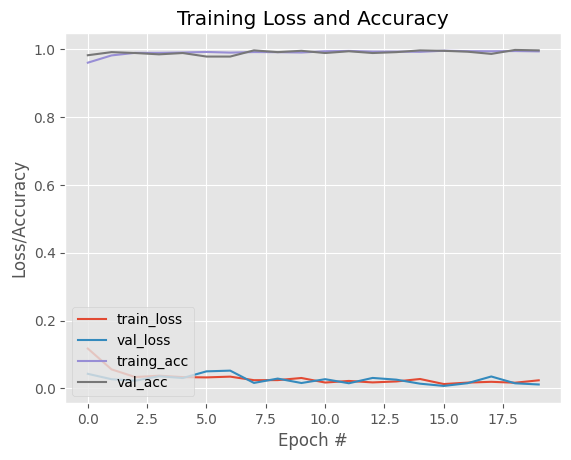

In [19]:
#plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),H.history['loss'],label='train_loss')
plt.plot(np.arange(0,N),H.history['val_loss'],label='val_loss')
plt.plot(np.arange(0,N),H.history['accuracy'],label='traing_acc')
plt.plot(np.arange(0,N),H.history['val_accuracy'],label='val_acc')
plt.title("Training Loss and Accuracy")
plt.xlabel('Epoch #')
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")